### 데이터 불러오기

In [26]:
# 라이브러리 임포트
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from xgboost import plot_importance
from sklearn.metrics import root_mean_squared_error, r2_score

In [2]:
# 데이터 불러오기
root = './data/'

# 원본
train = pd.read_csv(root + 'train.csv')
stores = pd.read_csv(root + 'stores.csv')
features = pd.read_csv(root + 'features.csv')

train.shape, stores.shape, features.shape

((421570, 5), (45, 3), (8190, 12))

In [3]:
# 데이터 범위 조정
train_m = train[train['Date'] > '2011-11-10']
train_m

,Store,Dept,Date,Weekly_Sales,IsHoliday
92,1,1,2011-11-11,18689.54,False
93,1,1,2011-11-18,19050.66,False
94,1,1,2011-11-25,20911.25,True
95,1,1,2011-12-02,25293.49,False
96,1,1,2011-12-09,33305.92,False
...,...,...,...,...,...
421565,45,98,2012-09-28,508.37,False
421566,45,98,2012-10-05,628.10,False
421567,45,98,2012-10-12,1061.02,False
421568,45,98,2012-10-19,760.01,False


In [4]:
fe = features[features['Date'] > '2011-11-10']
fe[['MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5']]= fe[['MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5']].fillna(0)
fe['MarkDown_S'] = fe['MarkDown1'] + fe['MarkDown2'] + fe['MarkDown3'] + fe['MarkDown4'] + fe['MarkDown5']
fe['MarkDown_A'] = fe['MarkDown_S'] / 5
fe.loc[:,'MarkDown_M'] = fe.loc[:, ['MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5']].max(axis=1)
fe.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4050 entries, 92 to 8189
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         4050 non-null   int64  
 1   Date          4050 non-null   object 
 2   Temperature   4050 non-null   float64
 3   Fuel_Price    4050 non-null   float64
 4   MarkDown1     4050 non-null   float64
 5   MarkDown2     4050 non-null   float64
 6   MarkDown3     4050 non-null   float64
 7   MarkDown4     4050 non-null   float64
 8   MarkDown5     4050 non-null   float64
 9   CPI           3465 non-null   float64
 10  Unemployment  3465 non-null   float64
 11  IsHoliday     4050 non-null   bool   
 12  MarkDown_S    4050 non-null   float64
 13  MarkDown_A    4050 non-null   float64
 14  MarkDown_M    4050 non-null   float64
dtypes: bool(1), float64(12), int64(1), object(1)
memory usage: 478.6+ KB


C:\Users\tkwi5\AppData\Local\Temp\ipykernel_27544\1271735850.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fe[['MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5']]= fe[['MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5']].fillna(0)
C:\Users\tkwi5\AppData\Local\Temp\ipykernel_27544\1271735850.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fe['MarkDown_S'] = fe['MarkDown1'] + fe['MarkDown2'] + fe['MarkDown3'] + fe['MarkDown4'] + fe['MarkDown5']
C:\Users\tkwi5\AppData\Local\Temp\ip

In [5]:
# 데이터 결합
# train + stores
m_df = pd.merge(train_m, stores, how = 'left', on = 'Store')

# train(new) + features
m_df = pd.merge(m_df, fe, how = 'left', on = ['Store', 'Date'])

# holiday 컬럼 처리
m_df = m_df.drop(columns='IsHoliday_x')
m_df = m_df.rename(columns={'IsHoliday_y':'IsHoliday'})

# 결합 원본
m_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 151432 entries, 0 to 151431
Data columns (total 19 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         151432 non-null  int64  
 1   Dept          151432 non-null  int64  
 2   Date          151432 non-null  object 
 3   Weekly_Sales  151432 non-null  float64
 4   Type          151432 non-null  object 
 5   Size          151432 non-null  int64  
 6   Temperature   151432 non-null  float64
 7   Fuel_Price    151432 non-null  float64
 8   MarkDown1     151432 non-null  float64
 9   MarkDown2     151432 non-null  float64
 10  MarkDown3     151432 non-null  float64
 11  MarkDown4     151432 non-null  float64
 12  MarkDown5     151432 non-null  float64
 13  CPI           151432 non-null  float64
 14  Unemployment  151432 non-null  float64
 15  IsHoliday     151432 non-null  bool   
 16  MarkDown_S    151432 non-null  float64
 17  MarkDown_A    151432 non-null  float64
 18  Mark

In [6]:
# 날짜 데이터 포맷
m_df["Date"] = pd.to_datetime(m_df["Date"])
m_df['Year'] = m_df['Date'].dt.year
m_df['Week'] = m_df['Date'].apply(lambda x: x.isocalendar()[1])

In [7]:
# 결측치 처리
m_df = m_df.fillna(0)
m_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 151432 entries, 0 to 151431
Data columns (total 21 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Store         151432 non-null  int64         
 1   Dept          151432 non-null  int64         
 2   Date          151432 non-null  datetime64[ns]
 3   Weekly_Sales  151432 non-null  float64       
 4   Type          151432 non-null  object        
 5   Size          151432 non-null  int64         
 6   Temperature   151432 non-null  float64       
 7   Fuel_Price    151432 non-null  float64       
 8   MarkDown1     151432 non-null  float64       
 9   MarkDown2     151432 non-null  float64       
 10  MarkDown3     151432 non-null  float64       
 11  MarkDown4     151432 non-null  float64       
 12  MarkDown5     151432 non-null  float64       
 13  CPI           151432 non-null  float64       
 14  Unemployment  151432 non-null  float64       
 15  IsHoliday     151

In [8]:
# sns.boxplot(m_df[['MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5']]);

In [9]:
# 평가 함수
def WMAE(y_true, y_pred, X_test):
    w = X_test['IsHoliday_le'].apply(lambda x: 5 if x==1 else 1)
    return np.round(np.sum(w*abs(y_true - y_pred)) / (np.sum(w)), 4)

def ER(y_true, y_pred, bin=30000):
    # y_true가 0인 데이터 제외 (walmart의 test데이터의 경우 18개)
    df_y = pd.DataFrame({'y_true': y_true, 'y_pred': y_pred})
    df_y = df_y[df_y['y_true'] != 0]

    # bin 기준으로 오차비율 확인
    # 하위
    y_true = df_y.loc[df_y['y_true']<=bin,'y_true']
    y_pred = df_y.loc[df_y['y_true']<=bin,'y_pred']
    ER_low = np.round(np.mean(abs((y_true - y_pred)/y_true)), 4)

    # 상위
    y_true = df_y.loc[df_y['y_true']>bin,'y_true']
    y_pred = df_y.loc[df_y['y_true']>bin,'y_pred']
    ER_high = np.round(np.mean(abs((y_true - y_pred)/y_true)), 4)
    return (ER_low, ER_high)

def get_score(model, y_true, y_pred, X_test, bin=30000):
    model_name = ''.join(filter(str.isalpha, str(type(model)).split('.')[-1]))
    wmae = WMAE(y_true, y_pred, X_test)
    rmse = root_mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    er = ER(y_true, y_pred, bin)
    print(f'{model_name}\nWMAE : {wmae}\nRMSE : {rmse:.4f}\nR2 : {r2:.4f}\nER(low,high) : {er}  기준 : {bin}')

In [10]:
## 인코딩
# 라벨 인코딩 : IsHoliday
le = LabelEncoder()

m_df['IsHoliday_le'] = le.fit_transform(m_df['IsHoliday'])

print(le.classes_, m_df['IsHoliday_le'].unique())

[False  True] [0 1]


In [11]:
## 스케일링
# stores 원본 테이블에서 size fit
sd_size = StandardScaler()
sd_size.fit(stores[['Size']])

for i in range(len(sd_size.mean_)):
    print(f'{sd_size.feature_names_in_[i]} 평균 : {sd_size.mean_[i]:.2f}, 표준편차 : {sd_size.scale_[i]:.2f}')

# features 원본 테이블에서 features fit
feature_cols = ['Temperature','Fuel_Price','MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5','CPI','Unemployment', 'MarkDown_S', 'MarkDown_A', 'MarkDown_M']
sd_feature = StandardScaler()
sd_feature.fit(fe[feature_cols])
for i in range(len(sd_feature.mean_)):
    print(f'{sd_feature.feature_names_in_[i]} 평균 : {sd_feature.mean_[i]:.2f}, 표준편차 : {sd_feature.scale_[i]:.2f}')

Size 평균 : 130287.60, 표준편차 : 63112.12
Temperature 평균 : 57.85, 표준편차 : 18.36
Fuel_Price 평균 : 3.62, 표준편차 : 0.27
MarkDown1 평균 : 7001.12, 표준편차 : 9252.83
MarkDown2 평균 : 2440.79, 표준편차 : 7619.35
MarkDown3 평균 : 1570.18, 표준편차 : 10663.25
MarkDown4 평균 : 2816.48, 표준편차 : 6386.77
MarkDown5 평균 : 4132.22, 표준편차 : 13085.07
CPI 평균 : 175.91, 표준편차 : 40.87
Unemployment 평균 : 7.24, 표준편차 : 1.70
MarkDown_S 평균 : 17960.78, 표준편차 : 23945.27
MarkDown_A 평균 : 3592.16, 표준편차 : 4789.05
MarkDown_M 평균 : 10881.44, 표준편차 : 19136.09


In [12]:
# fit한 스케일러들로 df 컬럼들 transform
feature_names = ['Temperature_sd','Fuel_Price_sd','MarkDown1_sd','MarkDown2_sd','MarkDown3_sd','MarkDown4_sd','MarkDown5_sd','CPI_sd','Unemployment_sd', 'MarkDown_S_sd', 'MarkDown_A_sd', 'MarkDown_M_sd']
m_df['Size_sd'] = sd_size.transform(m_df[['Size']])
m_df[feature_names] = sd_feature.transform(m_df[feature_cols])

m_df.head()

,Store,Dept,Date,Weekly_Sales,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,...,MarkDown1_sd,MarkDown2_sd,MarkDown3_sd,MarkDown4_sd,MarkDown5_sd,CPI_sd,Unemployment_sd,MarkDown_S_sd,MarkDown_A_sd,MarkDown_M_sd
0,1,1,2011-11-11,18689.54,A,151315,59.11,3.297,10382.90,6115.67,...,0.365487,0.482309,-0.127083,-0.064173,0.184883,1.029732,0.3709,0.322022,0.322022,-0.026052
1,1,1,2011-11-18,19050.66,A,151315,62.25,3.308,6074.12,254.39,...,-0.100185,-0.286953,-0.142377,-0.374068,0.141868,1.035174,0.3709,-0.215672,-0.215672,-0.251217
2,1,1,2011-11-25,20911.25,A,151315,60.14,3.236,410.31,98.00,...,-0.712302,-0.307478,5.086192,-0.439733,-0.273388,1.041220,0.3709,1.625205,1.625205,2.347609
3,1,1,2011-12-02,25293.49,A,151315,48.91,3.172,5629.51,68.00,...,-0.148237,-0.311416,-0.016137,-0.114586,1.248988,1.047267,0.3709,0.488397,0.488397,0.501350
4,1,1,2011-12-09,33305.92,A,151315,43.93,3.158,4640.65,19.00,...,-0.255108,-0.317847,-0.137403,0.128851,0.789419,1.053313,0.3709,0.204848,0.204848,0.187101


In [13]:
# 데이터셋 분리
X = m_df[['Store','Dept','Year','Week','IsHoliday_le','Size_sd','Temperature_sd','CPI_sd']]
X1 = m_df[['Store','Dept','Year','Week','IsHoliday_le','Size_sd','Temperature_sd','CPI_sd','MarkDown1_sd','MarkDown2_sd','MarkDown3_sd','MarkDown4_sd','MarkDown5_sd']]
X2 = m_df[['Store','Dept','Year','Week','IsHoliday_le','Size_sd','Temperature_sd','CPI_sd','MarkDown_S_sd']]
X3 = m_df[['Store','Dept','Year','Week','IsHoliday_le','Size_sd','Temperature_sd','CPI_sd','MarkDown_A_sd']]
X4 = m_df[['Store','Dept','Year','Week','IsHoliday_le','Size_sd','Temperature_sd','CPI_sd','MarkDown_M_sd']]
y = m_df['Weekly_Sales']

# IsHoliday 컬럼 분포를 따르게끔 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, 
                                                    random_state=73, stratify=m_df['IsHoliday'])
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y, test_size=0.3, shuffle=True, 
                                                    random_state=73, stratify=m_df['IsHoliday'])
print(X1_train.shape, X1_test.shape, y1_train.shape, y1_test.shape)
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y, test_size=0.3, shuffle=True, 
                                                    random_state=73, stratify=m_df['IsHoliday'])
print(X2_train.shape, X2_test.shape, y2_train.shape, y2_test.shape)
X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y, test_size=0.3, shuffle=True, 
                                                    random_state=73, stratify=m_df['IsHoliday'])
print(X3_train.shape, X3_test.shape, y3_train.shape, y3_test.shape)
X4_train, X4_test, y4_train, y4_test = train_test_split(X4, y, test_size=0.3, shuffle=True, 
                                                    random_state=73, stratify=m_df['IsHoliday'])
print(X4_train.shape, X4_test.shape, y4_train.shape, y4_test.shape)

(106002, 8) (45430, 8) (106002,) (45430,)
(106002, 13) (45430, 13) (106002,) (45430,)
(106002, 9) (45430, 9) (106002,) (45430,)
(106002, 9) (45430, 9) (106002,) (45430,)
(106002, 9) (45430, 9) (106002,) (45430,)


In [14]:
params = {'alpha': 2,
          'colsample_bytree': 0.9,
          'lambda': 10,
          'learning_rate': 0.3,
          'max_depth': 10,
          'min_child_weight': 5,
          'n_estimators': 1000, 
          'random_state': 73}

xgb = XGBRegressor(**params)
xgb_5 = XGBRegressor(**params)
xgb_s = XGBRegressor(**params)
xgb_a = XGBRegressor(**params)
xgb_m = XGBRegressor(**params)

xgb.fit(X_train, y_train)
xgb_5.fit(X1_train, y1_train)
xgb_s.fit(X2_train, y2_train)
xgb_a.fit(X3_train, y3_train)
xgb_m.fit(X4_train, y4_train)

y_pred = xgb.predict(X_test)
y1_pred = xgb_5.predict(X1_test)
y2_pred = xgb_s.predict(X2_test)
y3_pred = xgb_a.predict(X3_test)
y4_pred = xgb_m.predict(X4_test)

get_score(xgb, y_test, y_pred, X_test)
get_score(xgb_5, y1_test, y1_pred, X1_test)
get_score(xgb_s, y2_test, y2_pred, X2_test)
get_score(xgb_a, y3_test, y3_pred, X3_test)
get_score(xgb_m, y4_test, y4_pred, X4_test)

XGBRegressor
WMAE : 1625.6429
RMSE : 3000.9621
R2 : 0.9830
ER(low,high) : (40.4431, 0.0649)  기준 : 30000
XGBRegressor
WMAE : 1860.0037
RMSE : 3490.0559
R2 : 0.9771
ER(low,high) : (39.0391, 0.0747)  기준 : 30000
XGBRegressor
WMAE : 1667.6225
RMSE : 3151.6904
R2 : 0.9813
ER(low,high) : (40.7177, 0.0671)  기준 : 30000
XGBRegressor
WMAE : 1667.6225
RMSE : 3151.6904
R2 : 0.9813
ER(low,high) : (40.7177, 0.0671)  기준 : 30000
XGBRegressor
WMAE : 1668.7366
RMSE : 3319.4409
R2 : 0.9793
ER(low,high) : (34.877, 0.0678)  기준 : 30000


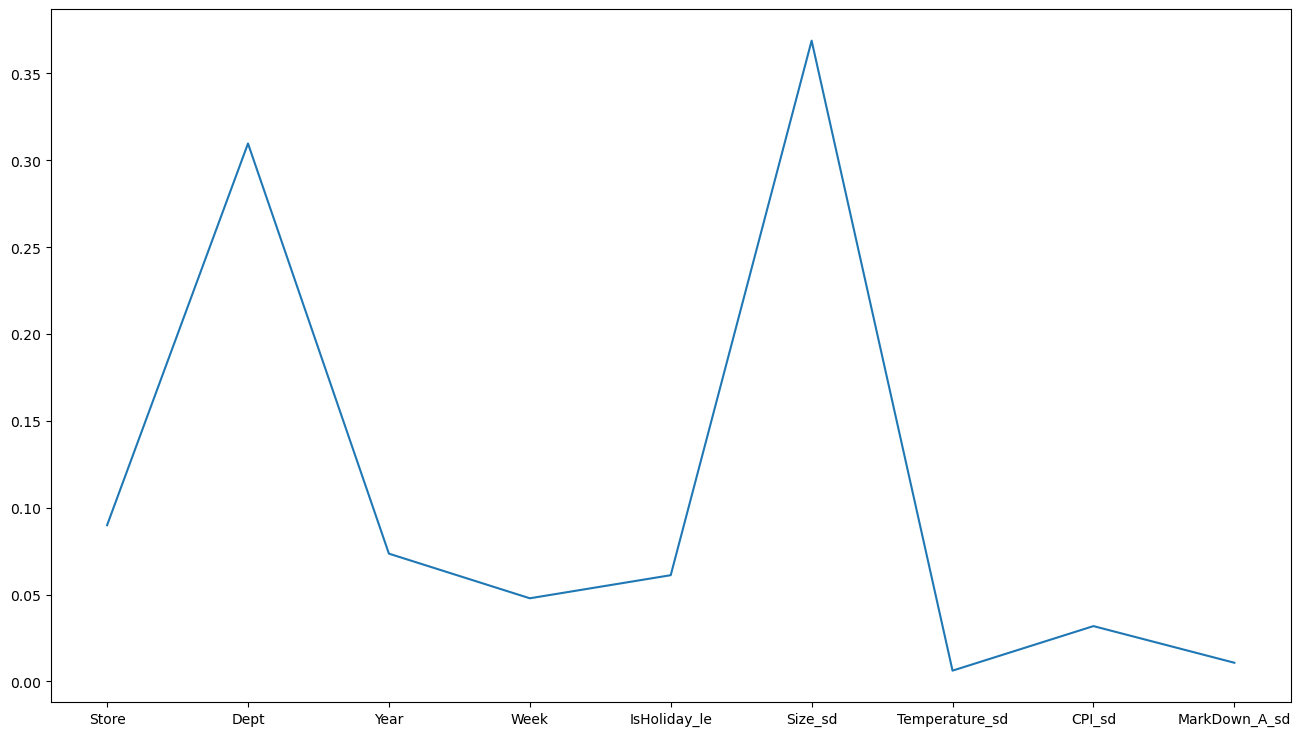

In [21]:
plt.figure(figsize=(16,9))
plt.plot(X3.columns, xgb_a.feature_importances_);

[Text(0, 0, 'Temperature_sd'),
 Text(0, 1, 'MarkDown_A_sd'),
 Text(0, 2, 'CPI_sd'),
 Text(0, 3, 'Week'),
 Text(0, 4, 'IsHoliday_le'),
 Text(0, 5, 'Year'),
 Text(0, 6, 'Store'),
 Text(0, 7, 'Dept'),
 Text(0, 8, 'Size_sd')]

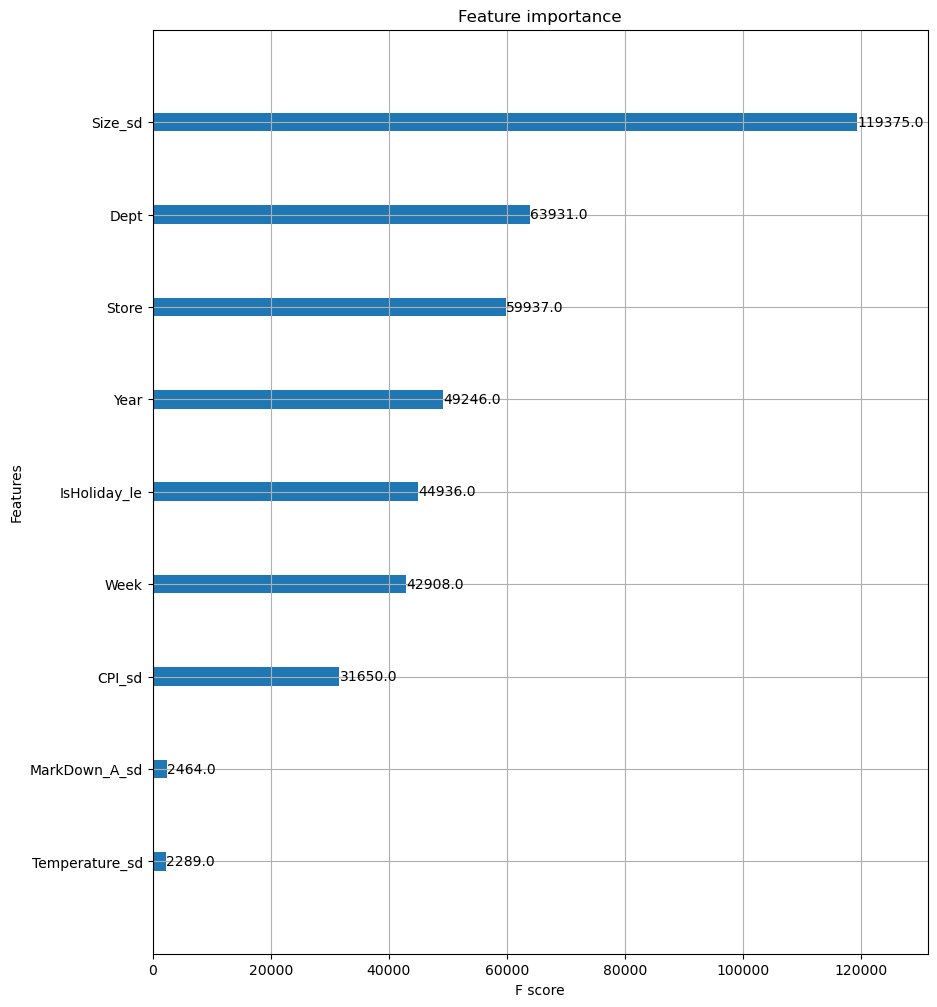

In [27]:
ftr_importances_values = xgb_a.feature_importances_
ftr_importances = pd.Series(ftr_importances_values,index=X3_train.columns  )
ftr_top20 = ftr_importances.sort_values(ascending=True)

fig, ax = plt.subplots(figsize = (10, 12))

plot_importance(xgb_a, ax = ax).set_yticklabels(ftr_top20.index)

In [53]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

A = m_df[['Store','Dept','Year','Week','IsHoliday_le','Size','Temperature',
          'CPI','MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5']]

vif = pd.DataFrame()

vif["VIF Factor"] = [variance_inflation_factor(X1.values, i) for i in range(A.shape[1])]
vif["features"] = A.columns 

# VIF 값이 높은 순으로 정렬
vif = vif.sort_values(by="VIF Factor", ascending=False)
vif = vif.reset_index().drop(columns='index')
vif

,VIF Factor,features
0,9.841100,Year
1,4.690179,Week
2,4.443640,Store
3,3.471406,MarkDown1
4,3.199230,MarkDown4
5,3.108460,Dept
6,1.588666,IsHoliday_le
7,1.328849,MarkDown3
8,1.326773,Size
9,1.322081,MarkDown2


In [54]:
xgb = XGBRegressor(random_state=73)
xgb_5 = XGBRegressor(random_state=73)
xgb_s = XGBRegressor(random_state=73)
xgb_a = XGBRegressor(random_state=73)
xgb_m = XGBRegressor(random_state=73)

xgb.fit(X_train, y_train)
xgb_5.fit(X1_train, y1_train)
xgb_s.fit(X2_train, y2_train)
xgb_a.fit(X3_train, y3_train)
xgb_m.fit(X4_train, y4_train)

y_pred = xgb.predict(X_test)
y1_pred = xgb_5.predict(X1_test)
y2_pred = xgb_s.predict(X2_test)
y3_pred = xgb_a.predict(X3_test)
y4_pred = xgb_m.predict(X4_test)

get_score(xgb, y_test, y_pred, X_test)
get_score(xgb_5, y1_test, y1_pred, X1_test)
get_score(xgb_s, y2_test, y2_pred, X2_test)
get_score(xgb_a, y3_test, y3_pred, X3_test)
get_score(xgb_m, y4_test, y4_pred, X4_test)

XGBRegressor
WMAE : 3125.6781
RMSE : 5115.6780
R2 : 0.9507
ER(low,high) : (62.7137, 0.1199)  기준 : 30000
XGBRegressor
WMAE : 3316.4209
RMSE : 5469.6044
R2 : 0.9437
ER(low,high) : (75.7094, 0.1297)  기준 : 30000
XGBRegressor
WMAE : 3215.9792
RMSE : 5323.0853
R2 : 0.9466
ER(low,high) : (66.9365, 0.1245)  기준 : 30000
XGBRegressor
WMAE : 3215.9792
RMSE : 5323.0853
R2 : 0.9466
ER(low,high) : (66.9365, 0.1245)  기준 : 30000
XGBRegressor
WMAE : 3178.7405
RMSE : 5339.5236
R2 : 0.9463
ER(low,high) : (74.6446, 0.1246)  기준 : 30000
